In [1]:
''' 
    Copyright (C) 2021 by Marinara Marcato
         <marinara.marcato@tyndall.ie>, Tyndall National Institute
        University College Cork, Cork, Ireland.
'''

# ------------------------------------------------------------------------- #
#                                  Imports                                  #    
# ------------------------------------------------------------------------- # 
import os, joblib, sys
from time import time
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV

from imblearn.ensemble import BalancedBaggingClassifier

import multiprocessing as mp
print("Number of Logical processors: ", mp.cpu_count())


# ------------------------------------------------------------------------- #
#                             Local Imports                                 #    
# ------------------------------------------------------------------------- # 

# Define local directories
dir_current = os.getcwd()
dir_base = os.path.dirname(dir_current)
dir_modules = os.path.join(dir_base, 'src', '__modules__')
# Set path variable
sys.path.append(dir_modules)

# Local Modules
import imports, analyse, learn, evaluate 

Number of Logical processors:  40


In [6]:
# ------------------------------------------------------------------------- #
#                              Directories                                  #    
# ------------------------------------------------------------------------- # 

# select dataset  
ft = 'final'

# directory where the dataset is located
dir_df = os.path.join(dir_base, 'data', ft)
# directory to save the model
dir_model = os.path.join(dir_base, 'models', ft)

# ------------------------------------------------------------------------- #
#                                   Classes                                 #    
# ------------------------------------------------------------------------- # 

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

class gs_results:
    # Storing Grid Search results
    def __init__(self, gs):
        self.cv_results_ = gs.cv_results_
        self.best_estimator_ = gs.best_estimator_
        self.best_params_ = gs.best_params_
        self.best_score_ = gs.best_score_

In [3]:

# ------------------------------------------------------------------------- #
#                              Importing Dataset                            #
# ------------------------------------------------------------------------- #
# importing previously created dataset
df = pd.read_csv(os.path.join(dir_base, 'data', 'final', 'df-all-dev.csv'), 
                index_col = ['Timestamp'], 
                parse_dates = ['Timestamp'],
                dayfirst = True,
                date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f')    )

# define all features 
feat = df.columns[:-6]
print(df.Position.value_counts('normalize'))

# prepare dataframe for evaluation: select features, label,
#   cv strategy (group = dogs, stractified folds labels proportion)
X = df.loc[:, feat]
y = df.loc[:, 'Position'].values
groups = df.loc[:,'Dog']

Position
body shake      82
lying down    3884
sitting       5096
standing      9286
walking       6418
Name: Position, dtype: int64


In [9]:
# source https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_bagging_classifier.html
from collections import Counter
from imblearn import FunctionSampler
import numpy as np

def roughly_balanced_bagging(X, y, replace=False):
    """Implementation of Roughly Balanced Bagging for binary problem."""
    # find the minority and majority classes
    class_counts = Counter(y)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    # compute the number of sample to draw from the majority class using
    # a negative binomial distribution
    n_minority_class = class_counts[minority_class]
    n_majority_resampled = np.random.negative_binomial(n=n_minority_class, p=0.5)

    # draw randomly with or without replacement
    majority_indices = np.random.choice(
        np.flatnonzero(y == majority_class),
        size=n_majority_resampled,
        replace=replace,
    )
    minority_indices = np.random.choice(
        np.flatnonzero(y == minority_class),
        size=n_minority_class,
        replace=replace,
    )
    indices = np.hstack([majority_indices, minority_indices])

    return X[indices], y[indices]

In [18]:
#                      Machine Learning - BBC                               #
pipe = Pipeline([ 
    ('ft', DataFrameSelector(feat,'float64')),
    ('slt', SelectKBest(score_func = f_classif)),
    ('clf', BalancedBaggingClassifier(
                    RandomForestClassifier(n_jobs = 1, max_features = None, 
                     class_weight = 'balanced', random_state = 0), 
                n_estimators = 500, 
                bootstrap = True,          # False before draw samples without replacement
                bootstrap_features= True,   # draw features with replacement
                sampling_strategy = 'majority', replacement = False, 
                n_jobs = -1, random_state = 0))
 
    ]) 

params = { 
            'slt__k':  [35, 55, 80], 
#             'slt__k':  [10, 20, 35, 55, 80, 110, 145], 
            'clf__base_estimator__max_depth': [3, 5, 7],
#             'clf__base_estimator__n_estimators': [25, 100, 500]
        }

In [ ]:
# OVER + UNDERSAMPLING
pipe = Pipeline([ 
    ('ft', DataFrameSelector(feat,'float64')),
    ('slt', SelectKBest(score_func = f_classif)),
    ('ovr', SMOTE(sampling_strategy=0.1)),
    ('und', RandomUnderSampler(sampling_strategy=0.5)),
    ('clf', RandomForestClassifier(n_jobs = 1, max_features = None, 
                 class_weight = 'balanced', random_state = 0))
    ])   

params = {
            'slt__k':  [55, 80, 110, 145],  
            'clf__max_depth': [3, 5, 7],
#             'clf__n_estimators': [25, 50, 100, 250, 500]
        }

In [ ]:
# select model name
exp = 5
mdl = 'imbalanced'
slt = 'SKB'
clf = 'RF'
param = 1 
run = '5-imbalanced-SKB-RF-1.pkl'

cv = GroupKFold(n_splits = 3).split(X, y, groups = groups)

start_time = time()
gs = GridSearchCV(pipe, param_grid = params, 
        scoring = 'f1_weighted', \
        n_jobs = 40, cv = cv, return_train_score = True)
gs.fit(X,y, groups = groups)
end_time = time()
duration = end_time - start_time
print("--- %s seconds ---" % (duration))

# save gs results to pickle file
gs_path = os.path.join(dir_current, run)
print(gs_path)
joblib.dump(gs_results(gs), gs_path, compress = 1)

In [19]:
# load grid search results from pickle file
gs_path = os.path.join(dir_base, 'jupyter')
gs_rf =  joblib.load(os.path.join(gs_path, run))
print('Evaluate Grid Search output\n')
evaluate.gs_output(gs_rf)

# add cv results to a dataframe 
df_cv = pd.DataFrame(gs_rf.cv_results_)
df_cv['train_test_gap'] = df_cv['mean_train_score'] - df_cv['mean_test_score']
opt = df_cv.filter(like = "param_").columns.to_list()
for col in opt: print(col, len(df_cv[col].unique()), df_cv[col].unique())
print('Hyperparameters combinations: ', df_cv.shape[0])

Evaluate Grid Search output

Best Estimator 
Test mean: 0.2386	 std: 0.0133
Train mean: 0.2380 	 std:  0.0063
parameters: {'clf__base_estimator__max_depth': 3, 'clf__base_estimator__n_estimators': 100, 'slt__k': 80}
param_clf__base_estimator__max_depth 3 [3 5 7]
param_clf__base_estimator__n_estimators 3 [25 100 500]
param_slt__k 3 [35 55 80]
Hyperparameters combinations:  27


In [12]:
# ------------------------------------------------------------------------- #
#                             Import Test data                              #
# ------------------------------------------------------------------------- #
print('\n\nImport Test Set\n')
# directory where the datasets are located
df_dir = os.path.join(dir_base, 'data', 'final')

# select test dataframe and label according to model
# EXPERIMENT 1 - DEFAULT
label = 'Position'
# df_test = imports.posture(df_dir, 'df-all-test')
df_test = pd.read_csv(os.path.join(dir_df, 'df-all-test.csv'), 
                index_col = ['Timestamp'], 
                parse_dates = ['Timestamp'],
                dayfirst = True,
                date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f')    )

print('Dataset:', df_test.shape)
print('Label:', df_test.groupby(label)[label].count())

# select test data for prediction
X_true = df_test.iloc[:,:-6]
y_true = df_test.loc[:, label]
labels = y_true.unique()




Import Test Set

Model: imbalanced
Dataset: (4866, 3336)
Label: Position
body shake      18
lying down     384
sitting        946
standing      2158
walking       1360
Name: Position, dtype: int64


        label  f1_score
0     walking  0.000000
1    standing  0.720014
2     sitting  0.000000
3  lying down  0.000000
4  body shake  0.026068

f1 scores
macro: 0.1492
micro: 0.4225
weighted: 0.3194


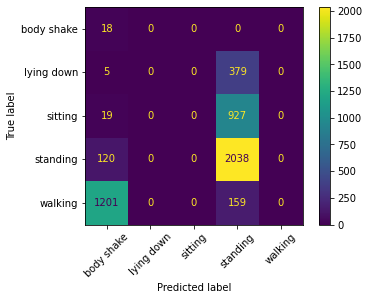

/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1618] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1618] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1618] are constant.
  warn

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

# ------------------------------------------------------------------------- #
#              Calculate f1-scores for model in Test Set                    #
# ------------------------------------------------------------------------- #
# Use best estimator to predict on test set
y_rf = gs_rf.best_estimator_.predict(X_true)

## Calculate f1-scores
df_f1_class = pd.DataFrame({
    'label':  labels,
    'f1_score': f1_score(y_true, y_rf, labels = labels, average = None)
})

print(df_f1_class)
print('\nf1 scores')
print('macro: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'macro')))
print('micro: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'micro')))
print('weighted: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'weighted')))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_rf, xticks_rotation = 45)
